# Project 1

## Goal of the analysis:

__Hypothesis:__  Counties with higher migration flows and high population density will exhibit higher infection rates of COVID-19.

__Goal of this analysis:__ Investigate the relationship between migration rates, population density, and COVID-19 infection rates, aiming to determine if a statistically significant correlation exists. Additionally, to identify counties or factors where the relationship appears to be particularly strong, providing insights into the impact of migration and population density on COVID-19 infection rates at a local level.



## Clearly state what the measurement is and the two factors 

* __Measurement:__ Infection rate
* __F1:__ Migration gross flow
* __F2:__ Population density


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Available data: obtained from CENSUS.gov

In [2]:
pop_file = "population.xlsx"
mig_file = "migration_flow.xlsx"
states = ["Florida", "Texas"]
pop_data = pd.read_excel(pop_file, sheet_name="population_filtered", engine='openpyxl')
mig_data = pd.read_excel(mig_file, sheet_name="migrationflow_filtered", engine='openpyxl')
grouped_data = mig_data.groupby(['STNAME', 'CTYNAME'])
sum_migration_by_county = grouped_data['GROSSMIG'].sum().reset_index()
#sum_migration_by_county

In [3]:
df = pd.read_csv("us-counties-2020.csv")

In [4]:
filtered_data = df[df['state'].isin(["Florida", "Texas"])]

In [5]:
#Filtered data
grouped_data = filtered_data.groupby(['state', 'county'])
sum_cases_by_county = grouped_data['cases'].sum().reset_index()
#sum_cases_by_county

In [6]:
## population density data
df_2 = pd.read_csv('pop.csv')
columns_to_keep = ['State','NAME', 'B01001_calc_PopDensity']
df_2 = df_2[columns_to_keep]

In [7]:
#create a condensed dataframe
#rate of infection calculation
sum_cases_by_county['rate of infection'] = sum_cases_by_county['cases'] / pop_data['ESTIMATESBASE2020']
sum_cases_by_county['population density'] = df_2['B01001_calc_PopDensity']
sum_cases_by_county['migration flow'] = sum_migration_by_county['GROSSMIG']
#print(sum_cases_by_county)
nan_count = sum_cases_by_county.isna().sum().sum()
#print(f"Total NaN values in the DataFrame: {nan_count}")

In [8]:
sum_cases_by_county.dropna(inplace=True)
#sum_cases_by_county

In [9]:
#high density pop?
average_densty = sum_cases_by_county['population density'].mean()
print(average_densty)
window_size = 60 #adjustable
def categorize_densty(popdens):
    if popdens <= (average_densty - window_size):
        return 1  # Level 1 low
    elif (average_densty - window_size) <popdens <= (average_densty + window_size):
        return 2  # Level 2 moderate
    else:
        return 3  # Level 3 high
sum_cases_by_county['density_level'] = sum_cases_by_county['population density'].apply(categorize_densty)
sum_cases_by_county

65.10910847528785


,state,county,cases,rate of infection,population density,migration flow,density_level
0,Florida,Alachua,1541591,5.535833,116.112210,49497.0,2
1,Florida,Baker,256360,9.070516,18.330993,4734.0,2
2,Florida,Bay,1127568,6.435743,92.885743,30225.0,2
3,Florida,Bradford,185658,6.558963,35.435175,5262.0,2
4,Florida,Brevard,1900201,3.132528,219.376463,58971.0,3
...,...,...,...,...,...,...,...
316,Texas,Winkler,32166,0.717111,26.218041,6456.0,2
317,Texas,Wise,209354,27.206498,4.138076,602.0,1
318,Texas,Wood,123270,6.899312,7.647755,1754.0,2
319,Texas,Yoakum,56753,4.086478,5.556724,1005.0,2


In [12]:
sum_cases_by_county['roi'] = np.log1p(sum_cases_by_county['rate of infection'])
sum_cases_by_county['mf'] = np.log1p(sum_cases_by_county['migration flow'])
#sum_cases_by_county['pd'] = np.log1p(sum_cases_by_county['population density'])
excel_file_path = 'sum_cases_by_county.xlsx'
sum_cases_by_county.to_excel(excel_file_path, index=False)

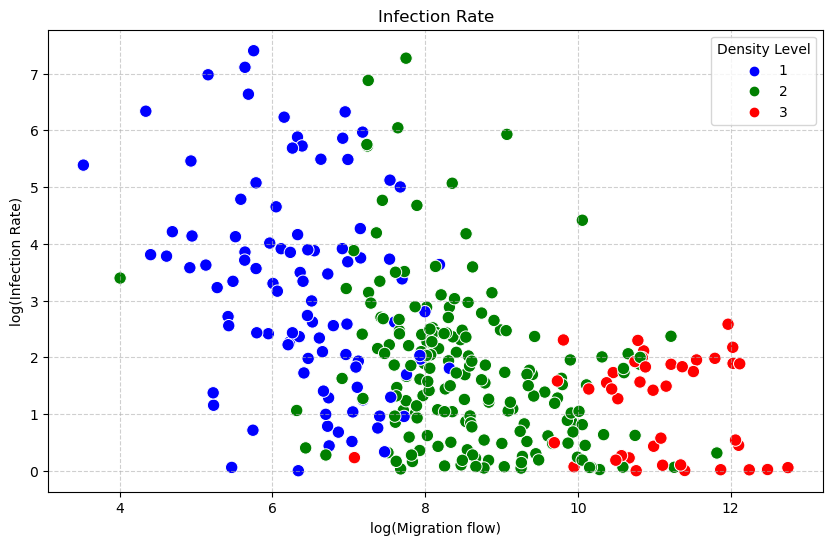

In [13]:
custom_palette = {1: 'blue', 2: 'green', 3: 'red'}
plt.figure(figsize=(10, 6))  
scatter_plot = sns.scatterplot(x='mf', y='roi', hue='density_level', data=sum_cases_by_county,palette=custom_palette, s=80) 
scatter_plot.legend(title='Density Level')
scatter_plot.set_title('Infection Rate')
scatter_plot.set_xlabel('log(Migration flow)')
scatter_plot.set_ylabel('log(Infection Rate)')

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

r_i = -1.85e-01 * density_level + -4.18e-01 * mf + 5.90e+00
                            OLS Regression Results                            
Dep. Variable:                    roi   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     57.12
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           6.37e-22
Time:                        10:37:48   Log-Likelihood:                -564.15
No. Observations:                 321   AIC:                             1134.
Df Residuals:                     318   BIC:                             1146.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

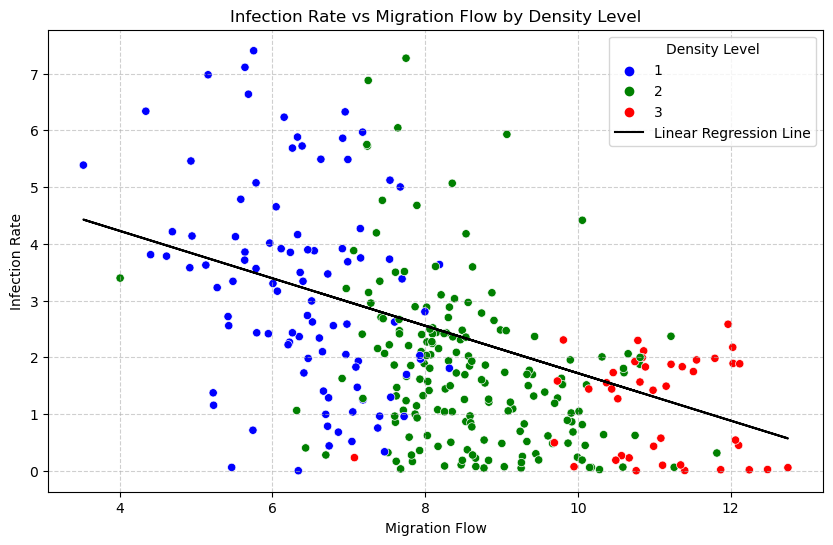

In [14]:
X = np.c_[np.ones(321), sum_cases_by_county['density_level'], sum_cases_by_county['mf']]
tmp = np.linalg.inv(np.matmul(np.transpose(X), X))
result1 = tmp @ np.transpose(X) @ sum_cases_by_county['roi']
print(f'r_i = {result1[1]:0.2e} * density_level + {result1[2]:0.2e} * mf + {result1[0]:0.2e}')
X_2 = sum_cases_by_county[['density_level', 'mf']]
X_2 = sm.add_constant(X_2)
y_2 = sum_cases_by_county['roi']

model = sm.OLS(y_2, X_2).fit()
slope = model.params['mf']
intercept = model.params['const']
print(model.summary())
plt.figure(figsize=(10, 6))

scatter_plot = sns.scatterplot(x='mf', y='roi', hue='density_level', data=sum_cases_by_county, palette=custom_palette)

x_values = sum_cases_by_county['mf']
linear_regression_line = slope * x_values + intercept
plt.plot(x_values, linear_regression_line, color='black', label='Linear Regression Line')

scatter_plot.set_title('Infection Rate vs Migration Flow by Density Level')
scatter_plot.set_xlabel('Migration Flow')
scatter_plot.set_ylabel('Infection Rate')

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Density Level')
plt.show()


In [17]:
sum_cases_by_county['Interaction Term'] = sum_cases_by_county['mf'] * sum_cases_by_county['density_level']
#print(sum_cases_by_county)
X_4 = sum_cases_by_county[['density_level','mf',  'Interaction Term']]
X_4 = sm.add_constant(X_4) 
y_3 = sum_cases_by_county['roi']
model_2 = sm.OLS(y_3, X_4).fit()
results_2 = model_2.summary()
print(results_2)

                            OLS Regression Results                            
Dep. Variable:                    roi   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     43.84
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           9.99e-24
Time:                        10:39:05   Log-Likelihood:                -557.71
No. Observations:                 321   AIC:                             1123.
Df Residuals:                     317   BIC:                             1139.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.2595      1.009  

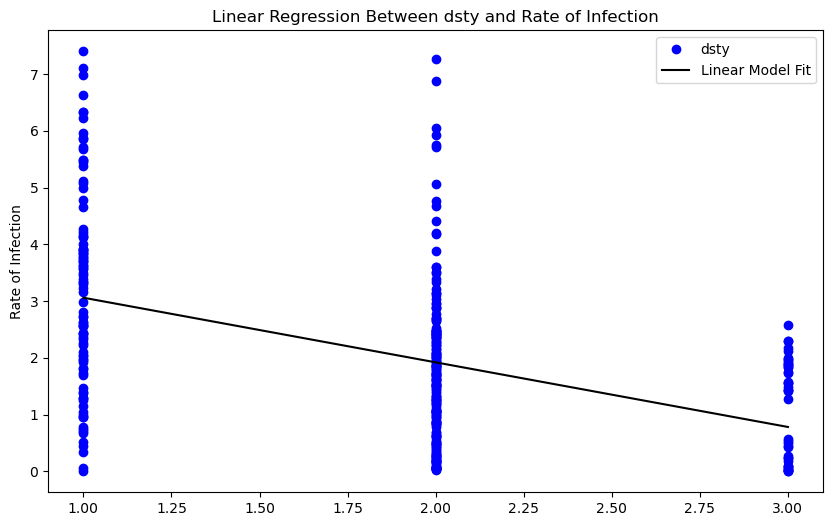

In [18]:
X_m = np.c_[np.ones(len(sum_cases_by_county)), sum_cases_by_county['density_level']]
y_m = sum_cases_by_county['roi']
X_m = sm.add_constant(X_m)
model = sm.OLS(y_m, X_m).fit()
INTERCEPT2, SLOPE2 = model.params[0], model.params[1]

tempx2 = [1, 2, 3]
plotting_temp2 = [SLOPE2 * x + INTERCEPT2 for x in tempx2]

plt.figure(figsize=(10, 6))  
plt.plot(sum_cases_by_county['density_level'], sum_cases_by_county['roi'], 'bo')
plt.plot(tempx2, plotting_temp2, 'k-')
plt.ylabel('Rate of Infection')
plt.title('Linear Regression Between dsty and Rate of Infection')
plt.legend(['dsty', 'Linear Model Fit'])
plt.show()

In [19]:
X_mig_flow = sum_cases_by_county['density_level']
X_mig_flow = sm.add_constant(X_mig_flow)

model_mig_flow = sm.OLS(y_m, X_mig_flow).fit()

print("Linear Regression for 'density_level' vs 'roi'")
print(model_mig_flow.summary())

Linear Regression for 'density_level' vs 'roi'
                            OLS Regression Results                            
Dep. Variable:                    roi   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     77.71
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           7.89e-17
Time:                        10:40:58   Log-Likelihood:                -578.43
No. Observations:                 321   AIC:                             1161.
Df Residuals:                     319   BIC:                             1168.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

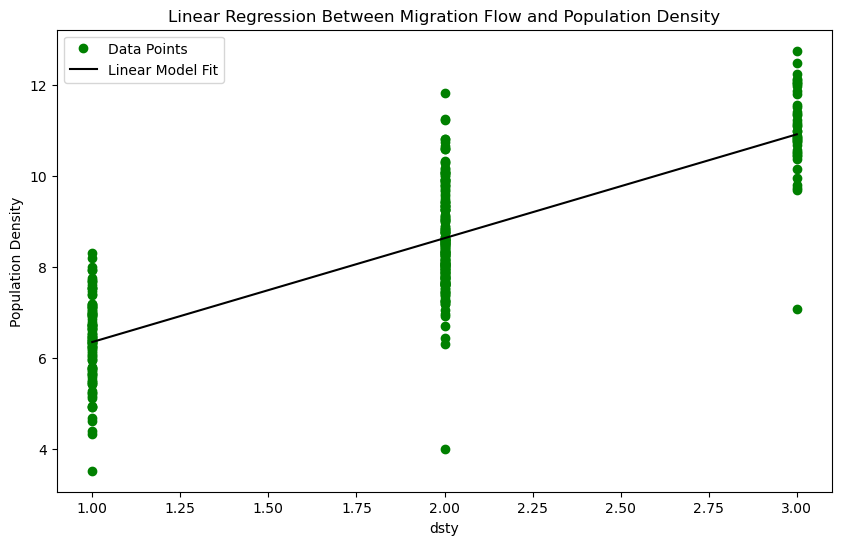

In [20]:
X_d = np.c_[np.ones(len(sum_cases_by_county)), sum_cases_by_county['density_level']]
y_d = sum_cases_by_county['mf']
X_d = sm.add_constant(X_d)

model_2 = sm.OLS(y_d, X_d).fit()
INTERCEPT2, SLOPE2 = model_2.params[0], model_2.params[1]

tempx3 = [1, 2, 3]
plotting_temp3 = [SLOPE2 * x + INTERCEPT2 for x in tempx3]
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(sum_cases_by_county['density_level'], sum_cases_by_county['mf'], 'go')
plt.plot(tempx3, plotting_temp3, 'k-')

plt.ylabel('Population Density')
plt.xlabel('dsty')
plt.title('Linear Regression Between Migration Flow and Population Density')

plt.legend(['Data Points', 'Linear Model Fit'])
plt.show()


In [21]:
X_density = sum_cases_by_county['mf']
X_density = sm.add_constant(X_density)
model_density = sm.OLS(y_d, X_density).fit()

print("Linear Regression for 'mf' vs 'roi'")
print(model_density.summary())

Linear Regression for 'mf' vs 'roi'
                            OLS Regression Results                            
Dep. Variable:                     mf   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.634e+36
Date:                Mon, 30 Oct 2023   Prob (F-statistic):               0.00
Time:                        10:42:39   Log-Likelihood:                 11818.
No. Observations:                 321   AIC:                        -2.363e+04
Df Residuals:                     319   BIC:                        -2.363e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.16